### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [105]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [106]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [107]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [108]:
# Functions for Optuna NNs

def create_snnn_model_hyperpars(neurons_base=4, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

    
def objective(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=1, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        score = model.evaluate(X_val, y_val, verbose=0)
        return score[1]

(79162, 41)

(6405, 41)

(6311, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    6405.000000
mean      285.996565
std         0.816362
min       285.000000
25%       285.000000
50%       286.000000
75%       287.000000
max       287.000000
Name: prd, dtype: float64

count    6311.000000
mean      288.997782
std         0.816235
min       288.000000
25%       288.000000
50%       289.000000
75%       290.000000
max       290.000000
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (6405, 85) (6616, 85) (6311, 85)
mae of a constant model 8.616058689352922
R2 of a constant model 0.0
fixed XGB train: 8.094503280537975 0.08807399835850738
XGB val: 7.80268307196985 -0.012211276662149384
XGB val extra: 9.182509786895938 0.006809524790626353
XGB test: 7.84572645024662 0.015254350212336232
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} -0.009211110247068666 60.70800852775574
XGB train: 8.232025093474888 0.060695330008433745
XGB validation: 7.630334731974988 0.032497740585895496
XGB validation extra: 8.985427732621966 0.05388213675932696
XGB test: 7.787969462570123 0.02523901836111997


[I 2022-09-08 00:08:47,867] A new study created in memory with name: no-name-cdd3ead3-8259-44b0-bbe9-1dc4e7a5421d
[I 2022-09-08 00:08:48,403] Trial 0 finished with value: -0.0012048216757048814 and parameters: {'n_estimators': 1306, 'max_depth': 4, 'learning_rate': 0.015071810988281401, 'colsample_bytree': 0.26474742666067314, 'subsample': 0.6070279997207064, 'alpha': 0.48907928615591034, 'lambda': 0.14700210657215615, 'gamma': 1.1763151996419365e-06, 'min_child_weight': 4.3779151945391295}. Best is trial 0 with value: -0.0012048216757048814.
[I 2022-09-08 00:08:48,914] Trial 1 finished with value: -0.0010697418240821043 and parameters: {'n_estimators': 1280, 'max_depth': 2, 'learning_rate': 0.0017415735238563118, 'colsample_bytree': 0.7212926555530897, 'subsample': 0.8773619729643917, 'alpha': 5.50795930747284, 'lambda': 0.5232986375508525, 'gamma': 7.506831006911341e-06, 'min_child_weight': 0.5014476100005251}. Best is trial 1 with value: -0.0010697418240821043.
[I 2022-09-08 00:08:4

Total time for hypermarameter optimization  16.083224058151245
        n_estimators : 1332
           max_depth : 5
       learning_rate : 0.018429567583991103
    colsample_bytree : 0.052419231650879056
           subsample : 0.5122602743826856
               alpha : 0.9807585035231575
              lambda : 1.6646041621394538
               gamma : 1.2226827554418907e-10
    min_child_weight : 16.648691907389352
best objective value : 0.0007684651083394333
Optuna XGB train: 
 8.024671593882209 0.10433083548073063 
validation 
 7.5730147124431175 0.05580123985973873 9.127795451071636 0.018697863872178533 
test 
 7.775516775755487 0.03183585537127076
3801
Epoch 1/1000
39/39 [==============================] - 1s 9ms/step - loss: 170.8631 - mean_squared_error: 135.1082 - val_loss: 150.2069 - val_mean_squared_error: 120.2894
Epoch 2/1000
39/39 [==============================] - 0s 4ms/step - loss: 159.5051 - mean_squared_error: 133.7673 - val_loss: 142.6587 - val_mean_squared_error: 120.8

[I 2022-09-08 00:10:51,255] A new study created in memory with name: no-name-a3c8347c-fb67-4f27-a26e-717c81a72c83
[I 2022-09-08 00:10:51,787] Trial 0 finished with value: -0.001065448713621775 and parameters: {'n_estimators': 820, 'max_depth': 3, 'learning_rate': 0.00357892061320079, 'colsample_bytree': 0.30516678753738263, 'subsample': 0.34732471358363476, 'alpha': 38.623541147018315, 'lambda': 174.32310229508786, 'gamma': 0.0034689556476506117, 'min_child_weight': 0.386695921484939}. Best is trial 0 with value: -0.001065448713621775.
[I 2022-09-08 00:10:53,211] Trial 1 finished with value: -0.0014238655108142373 and parameters: {'n_estimators': 836, 'max_depth': 6, 'learning_rate': 0.001593810151618883, 'colsample_bytree': 0.5262113096356211, 'subsample': 0.19011974134923948, 'alpha': 42.1284852557004, 'lambda': 0.5079946496587071, 'gamma': 1.4629667543389158e-06, 'min_child_weight': 0.6327796219125237}. Best is trial 1 with value: -0.0014238655108142373.
[I 2022-09-08 00:10:53,730] 

{'n_estimators': 1201,
 'max_depth': 5,
 'learning_rate': 0.02725092171474692,
 'colsample_bytree': 0.9398155801227961,
 'subsample': 0.29217762490604765,
 'alpha': 1.6221820521451933,
 'lambda': 0.35402986387161695,
 'gamma': 1.0674070093548641e-05,
 'min_child_weight': 3.6210397585461327}

32.262818574905396

[1201,
 5,
 0.02725092171474692,
 0.9398155801227961,
 0.29217762490604765,
 1.6221820521451933,
 0.35402986387161695,
 1.0674070093548641e-05,
 3.6210397585461327]

[1201, 5, 0.02725092171474692, 0.9398155801227961, 0.29217762490604765, 1.6221820521451933, 0.35402986387161695, 1.0674070093548641e-05, 3.6210397585461327]
Epoch 1/1000
39/39 [==============================] - 2s 39ms/step - loss: 24144.8145 - mean_squared_error: 143.7024 - val_loss: 13595.3350 - val_mean_squared_error: 119.5684
Epoch 2/1000
39/39 [==============================] - 1s 35ms/step - loss: 10021.6631 - mean_squared_error: 133.9535 - val_loss: 7045.6255 - val_mean_squared_error: 119.5412
Epoch 3/1000
39/39 [==============================] - 1s 34ms/step - loss: 5300.6519 - mean_squared_error: 134.4140 - val_loss: 3757.8899 - val_mean_squared_error: 119.9640
Epoch 4/1000
39/39 [==============================] - 1s 34ms/step - loss: 2830.7932 - mean_squared_error: 134.3777 - val_loss: 1998.8658 - val_mean_squared_error: 120.0636
Epoch 5/1000
39/39 [==============================] - 1s 34ms/step - loss: 1513.1777 - mean_squared_error: 134.4076 - val_loss: 1065.9143 - val_mean

(86525, 41)

(7274, 41)

(7655, 41)

count    86525.000000
mean       366.510604
std         10.388374
min        349.000000
25%        357.000000
50%        366.000000
75%        376.000000
max        384.000000
Name: prd, dtype: float64

count    7274.000000
mean      386.036294
std         0.824686
min       385.000000
25%       385.000000
50%       386.000000
75%       387.000000
max       387.000000
Name: prd, dtype: float64

count    7655.000000
mean      388.997518
std         0.816199
min       388.000000
25%       388.000000
50%       389.000000
75%       390.000000
max       390.000000
Name: prd, dtype: float64

Number of features before transformation:  (86525, 38)
time to do feature proprocessing: 
Number of features after transformation:  (86525, 86) (7274, 86) (7557, 86) (7655, 86)
mae of a constant model 9.829729636954092
R2 of a constant model 0.0
fixed XGB train: 8.691436727915313 0.10293313911685331
XGB val: 9.717708335125423 0.03999212025983656
XGB val extra: 12.284157764400447 0.03759872132638431
XGB test: 10.465530780239735 -0.0063821723842552025
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04241707807354467 63.41380167007446
XGB train: 8.695012267727543 0.09907150614417448
XGB validation: 9.559585257648125 0.070611187303669
XGB validation extra: 11.972006867399784 0.08163841109742664
XGB test: 10.47468523195892 -0.0059672654136349035


[I 2022-09-08 00:16:00,187] A new study created in memory with name: no-name-32fc6332-ee87-4bd5-99e8-0b7d1ecef52b
[I 2022-09-08 00:16:05,030] Trial 0 finished with value: 0.030444592228840793 and parameters: {'n_estimators': 1482, 'max_depth': 3, 'learning_rate': 0.011462897936328341, 'colsample_bytree': 0.6344108930624238, 'subsample': 0.6334914834289403, 'alpha': 0.43881341697327675, 'lambda': 12.136501206613376, 'gamma': 0.0031219902341605267, 'min_child_weight': 0.28469615674470355}. Best is trial 0 with value: 0.030444592228840793.
[I 2022-09-08 00:16:09,851] Trial 1 finished with value: 0.030324004722462237 and parameters: {'n_estimators': 1489, 'max_depth': 3, 'learning_rate': 0.011994011494864775, 'colsample_bytree': 0.6021697117025985, 'subsample': 0.439003964984758, 'alpha': 7.897580554366846, 'lambda': 453.5567921314006, 'gamma': 3.5857552633495384e-06, 'min_child_weight': 34.03360261006201}. Best is trial 0 with value: 0.030444592228840793.
[I 2022-09-08 00:16:14,660] Trial

Total time for hypermarameter optimization  67.57512211799622
        n_estimators : 1310
           max_depth : 2
       learning_rate : 0.02974674991074891
    colsample_bytree : 0.06642030698540989
           subsample : 0.8941075006603154
               alpha : 48.013045649816654
              lambda : 1.4964615527133536
               gamma : 4.775506080351565e-07
    min_child_weight : 4.211452097881602
best objective value : 0.034406388600904704
Optuna XGB train: 
 8.714828834344921 0.09020851846838462 
validation 
 9.59224620935269 0.05962044138785372 12.21332807491869 0.04228581994108982 
test 
 10.40795175896834 0.0032516626625225253
3833
Epoch 1/1000
43/43 [==============================] - 1s 9ms/step - loss: 207.5803 - mean_squared_error: 171.1434 - val_loss: 227.3128 - val_mean_squared_error: 196.8032
Epoch 2/1000
43/43 [==============================] - 0s 5ms/step - loss: 195.4296 - mean_squared_error: 169.0661 - val_loss: 218.4505 - val_mean_squared_error: 195.8468
Epo

[I 2022-09-08 00:18:54,476] A new study created in memory with name: no-name-ce79a537-9714-4ad0-981e-5c6323f4fffa
[I 2022-09-08 00:19:00,742] Trial 0 finished with value: 0.028800265899530816 and parameters: {'n_estimators': 1360, 'max_depth': 4, 'learning_rate': 0.0067218192163697125, 'colsample_bytree': 0.6146344828369336, 'subsample': 0.42989554604193214, 'alpha': 0.42279536368333126, 'lambda': 5.4480484868366625, 'gamma': 1.3705425333064778, 'min_child_weight': 2.4758240140443255}. Best is trial 0 with value: 0.028800265899530816.
[I 2022-09-08 00:19:02,621] Trial 1 finished with value: 0.027554362185061087 and parameters: {'n_estimators': 1164, 'max_depth': 2, 'learning_rate': 0.02841014090837749, 'colsample_bytree': 0.8222927737763531, 'subsample': 0.2711160688925927, 'alpha': 1.9899151932096242, 'lambda': 1.5666173916903752, 'gamma': 0.0068090032785664304, 'min_child_weight': 1.1771932092903759}. Best is trial 1 with value: 0.027554362185061087.
[I 2022-09-08 00:19:06,808] Trial

{'n_estimators': 1164,
 'max_depth': 3,
 'learning_rate': 0.0005120579596010605,
 'colsample_bytree': 0.07367463356112161,
 'subsample': 0.8489062961365692,
 'alpha': 0.30180528038924737,
 'lambda': 0.7943695578002472,
 'gamma': 2.0853023255534483e-05,
 'min_child_weight': 8.589529879397269}

218.95517897605896

[1164,
 3,
 0.0005120579596010605,
 0.07367463356112161,
 0.8489062961365692,
 0.30180528038924737,
 0.7943695578002472,
 2.0853023255534483e-05,
 8.589529879397269]

[1164, 3, 0.0005120579596010605, 0.07367463356112161, 0.8489062961365692, 0.30180528038924737, 0.7943695578002472, 2.0853023255534483e-05, 8.589529879397269]
Epoch 1/1000
43/43 [==============================] - 2s 35ms/step - loss: 15161.3477 - mean_squared_error: 209.2728 - val_loss: 8498.3408 - val_mean_squared_error: 195.2033
Epoch 2/1000
43/43 [==============================] - 1s 32ms/step - loss: 5990.0034 - mean_squared_error: 168.5075 - val_loss: 4029.0747 - val_mean_squared_error: 197.3360
Epoch 3/1000
43/43 [==============================] - 1s 32ms/step - loss: 2917.7300 - mean_squared_error: 168.7761 - val_loss: 2026.4205 - val_mean_squared_error: 195.0898
Epoch 4/1000
43/43 [==============================] - 1s 32ms/step - loss: 1476.8694 - mean_squared_error: 168.7829 - val_loss: 1059.9646 - val_mean_squared_error: 197.3123
Epoch 5/1000
43/43 [==============================] - 1s 32ms/step - loss: 779.5576 - mean_squared_error: 169.3009 - val_loss: 593.2016 - val_mean_sq

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.104331,0.055801,0.031836,0.082207,-0.001591,0.003317,0.07451,-0.003778,0.005787,0.073802,0.001303,0.010754,-0.000017,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.090209,0.05962,0.003252,0.094762,0.046216,-0.007163,0.092474,0.04963,-0.00976,0.090635,0.05024,0.000841,0.066228,0.04182,-0.000762,NaN,NaN,NaN


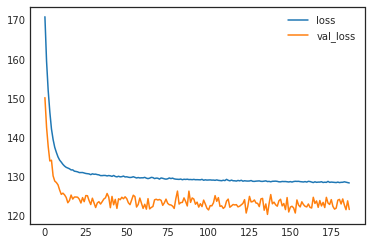

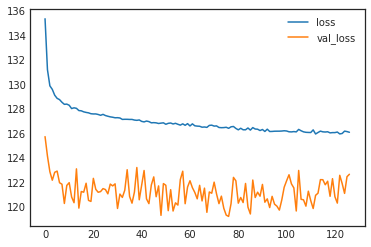

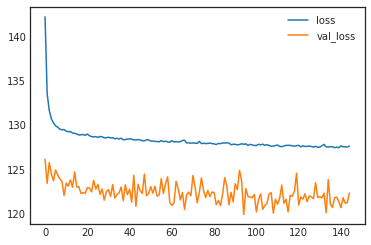

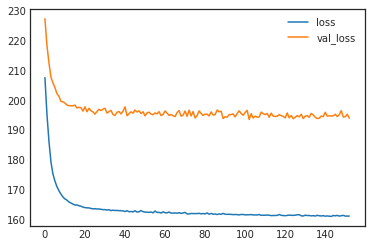

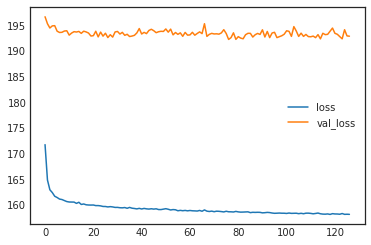

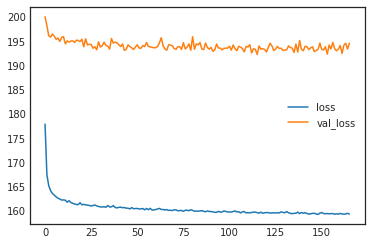

In [109]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [250, 350, 450, 550]
# min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn2_train', 'nn2_val', 'nn2_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test',
                                 'nn6opt_train', 'nn6opt_val', 'nn6opt_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]
    
    ###########
    ### NNs ###
    ###########
    
    neurons_base = 8
    l2_reg_rate = 0.5

    model_snn6 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn6.count_params())

    early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
    optimizer_adam = tf.keras.optimizers.Adam()

    model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
    [r2_score(y_train, model_snn6.predict(X_train)), 
    r2_score(y_val, model_snn6.predict(X_val)),
    r2_score(y_test, model_snn6.predict(X_test))]
    
    
    
    neurons_base = 8
    l2_reg_rate = 0.1

    model_snn2 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn2.count_params())

    model_snn2.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn2.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn2_train':'nn2_test'] = \
    [r2_score(y_train, model_snn2.predict(X_train)), 
    r2_score(y_val, model_snn2.predict(X_val)),
    r2_score(y_test, model_snn2.predict(X_test))]
    
    
    neurons_base = 8
    l2_reg_rate = 0.3

    model_snn4 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn4.count_params())

    time1 = time.time()
    model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
    [r2_score(y_train, model_snn4.predict(X_train)), 
    r2_score(y_val, model_snn4.predict(X_val)),
    r2_score(y_test, model_snn4.predict(X_test))]
    
    
    
    # try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

    time1 = time.time()

    trials = 50

    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective, n_trials=trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display(study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print(time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=1, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    display(results)
    
display(results)

In [110]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train      0.095504
xgbf_val        0.013890
xgbf_test       0.004436
xgbgs_train     0.079883
xgbgs_val       0.051554
xgbgs_test      0.009636
xgbo_train      0.097270
xgbo_val        0.057711
xgbo_test       0.017544
nn2_train       0.088485
nn2_val         0.022312
nn2_test       -0.001923
nn4_train       0.083492
nn4_val         0.022926
nn4_test       -0.001987
nn6_train       0.082218
nn6_val         0.025772
nn6_test        0.005798
nn4opt_train    0.033106
nn4opt_val      0.020910
nn4opt_test    -0.000382
nn6opt_train         NaN
nn6opt_val           NaN
nn6opt_test          NaN
dtype: float64

1088.1573128700256


In [111]:
results

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.104331,0.055801,0.031836,0.082207,-0.001591,0.003317,0.07451,-0.003778,0.005787,0.073802,0.001303,0.010754,-0.000017,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.090209,0.05962,0.003252,0.094762,0.046216,-0.007163,0.092474,0.04963,-0.00976,0.090635,0.05024,0.000841,0.066228,0.04182,-0.000762,NaN,NaN,NaN


In [114]:
optimal_hyperpars

[1164,
 3,
 0.0005120579596010605,
 0.07367463356112161,
 0.8489062961365692,
 0.30180528038924737,
 0.7943695578002472,
 2.0853023255534483e-05,
 8.589529879397269]

In [112]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [113]:
# try optuna for NN:

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3)
    model = tf.keras.Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    display(model.summary())
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


[I 2022-09-08 00:25:49,129] A new study created in memory with name: no-name-806a59eb-b0e4-4b28-a0b9-19a8cf7256ce
[W 2022-09-08 00:25:49,138] Trial 0 failed because of the following error: ValueError('This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_17/3767762731.py", line 11, in objective
    display(model.summary())
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2521, in summary
    raise ValueError('This model has not yet been built. '
ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for 

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
model_snn.summary()

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [ ]:
# usually self-norm seems better: it overfits less and runs faster

